2.19.0


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 2/40
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 3/40
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 4/40
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/40
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/40
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/40
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/40
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/40
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/40
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 11/40
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 12/

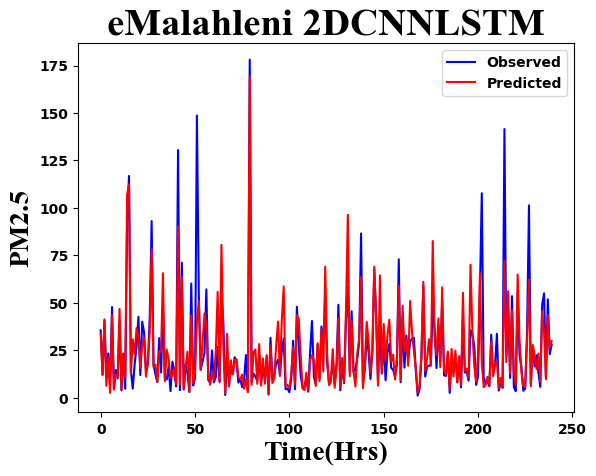

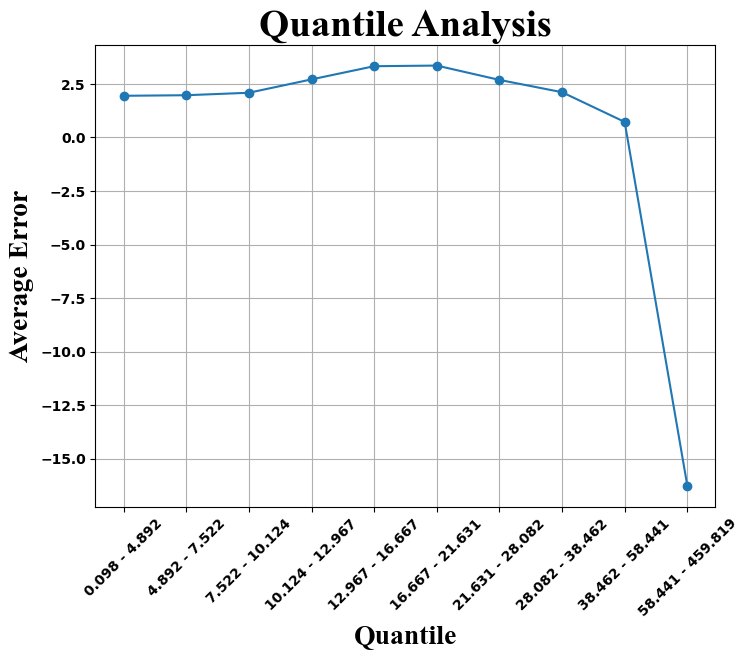

In [1]:
import numpy as np
import pandas as pd
from math import sqrt 
import matplotlib.pyplot as plt 
from matplotlib import rcParams
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


#%matplotlib inline
#%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

# 1) Load & merge two stations 
stations = ['eMalahleni','Middelburg']

# 1) Load & merge two stations 
stations = ['eMalahleni','Middelburg']
dfs = []
for st in stations:
    df = pd.read_csv(f'C:\\Users\\User\\Documents\\GitHub\\Health-impacts-of-air-pollution\\AirData\\{st}IM.csv', sep=';', header=0, index_col=0)
    # rename to keep track
    df.columns = [f'{st}_{c}' for c in df.columns]
    dfs.append(df)
data = pd.concat(dfs, axis=1).dropna()

values = data.values

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

data.columns

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

n_vars = scaled.shape[1] 

drop = list(range(n_vars+1, 2*n_vars))
reframed.drop(reframed.columns[drop], axis=1, inplace=True)
values = reframed.values

X = values[:,:-1]

Y = values[:,-1]

n_stations = len(stations)  
n_feats    = int(n_vars / n_stations)
n_in      = 1

X = X.reshape(X.shape[0],n_in,n_stations,n_feats,1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

model = Sequential()
# 2) apply a small 2D conv over the station×feature “grid” at each time step
model.add(TimeDistributed(Conv2D(filters=64,kernel_size=(2,2),      # your choice; must be <= (n_stations, n_feats)
      activation='relu', padding='same'),input_shape=(None, n_stations, n_feats, 1)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(TimeDistributed(Conv2D(filters=64,kernel_size=(2,2), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(1,2))))
model.add(TimeDistributed(Conv2D(filters=64,kernel_size=(2,2), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(1,2))))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(56))
model.add(Dense(56, activation="relu"))
model.add(Dense(56, activation="relu"))
model.add(Dense(1, activation='linear'))   # use 'linear' for regression
model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, batch_size=32, verbose=1)

prediction = model.predict(X_test)

def unscale(scaled_value):
    # if target variable is the first column, then, data_max_[0]
    unscaled_value = scaled_value * (scaler.data_max_[0] - scaler.data_min_[0]) + (scaler.data_min_[0])
    return unscaled_value

predictions = unscale(prediction)

Y_tests = unscale(Y_test)

mean_absolute_error(Y_tests, predictions)

rmse = sqrt(mean_squared_error(Y_tests, predictions))
print(rmse)

r2_score(Y_tests, predictions)

print('accuracy testing = {}'.format(np.sum(prediction==Y_test)))


rcParams['font.weight'] = 'bold'
plt.plot(Y_tests[0:240], color='blue', label = 'Observed')
plt.plot(predictions[0:240], color='red', label = 'Predicted')
plt.ylabel('PM2.5', fontname="Times New Roman", size=20,fontweight="bold")
plt.xlabel('Time(Hrs)', fontname="Times New Roman", size=20,fontweight="bold")
plt.title('eMalahleni 2DCNNLSTM', fontname="Times New Roman", size=28,fontweight="bold")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)
plt.show()

errors = predictions.flatten() - Y_tests

# Calculate quantiles based on actual values
quantiles, bins = pd.qcut(Y_tests, q=10, duplicates='drop', retbins=True)

# Calculate average error for each quantile
quantile_errors = []
for i in range(len(bins) - 1):
    group_indices = np.where((Y_tests >= bins[i]) & (Y_tests < bins[i+1]))[0]
    quantile_errors.append(errors[group_indices].mean())

# Round the bin edges for better readability
rounded_bins = np.round(bins, decimals=3)

# Plot quantiles vs. average errors
rcParams['font.weight'] = 'bold'
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(quantiles.categories) + 1), quantile_errors, marker='o')
plt.xlabel('Quantile', fontname="Times New Roman", size=20, fontweight="bold")
plt.ylabel('Average Error', fontname="Times New Roman", size=20, fontweight="bold")
plt.title('Quantile Analysis', fontname="Times New Roman", size=28, fontweight="bold")
plt.xticks(range(1, len(quantiles.categories) + 1), [f'{rounded_bins[i]:.3f} - {rounded_bins[i+1]:.3f}' for i in range(len(rounded_bins) - 1)], rotation=45)
plt.grid(True)
plt.show()

model.save('2D_lstmcnn_model.h5')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step
1/1 ━━━━━━━━━━━━

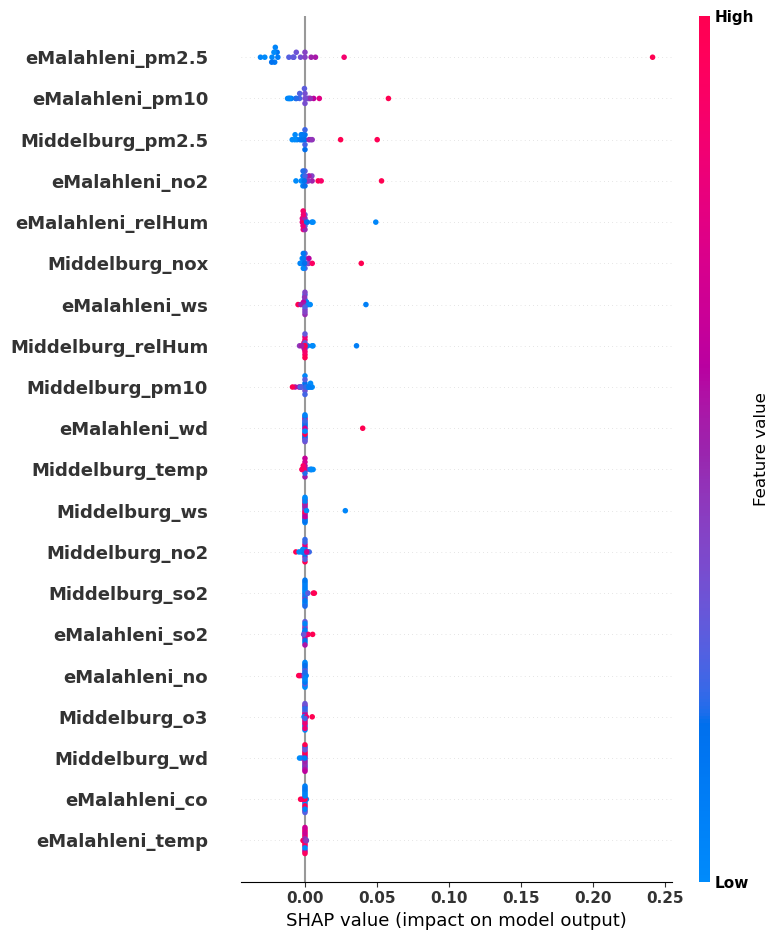

In [2]:
# ─── PART 3: SHAP EXPLAINER ───
# Run this only after you’ve trained your 2D CNN–LSTM model above,
# and in a fresh kernel (so that shap isn’t already imported).

import shap
import numpy as np

# 1) Flatten your inputs:
#    X_train.shape == (N, 1, n_stations, n_feats, 1)
#    -> bg_flat.shape == (N, n_stations*n_feats)
bg_flat  = X_train.reshape(X_train.shape[0], -1)
test_flat = X_test.reshape(X_test.shape[0], -1)

# 2) Subsample for speed
B = min(100, bg_flat.shape[0])
T = min(20, test_flat.shape[0])
bg_idx   = np.random.choice(bg_flat.shape[0], B, replace=False)
test_idx = np.random.choice(test_flat.shape[0], T, replace=False)
bg_sample   = bg_flat[bg_idx]
test_sample = test_flat[test_idx]

# 3) Wrap your model’s predict to accept 2D arrays
f = lambda x: model.predict(
    x.reshape(-1, 1, n_stations, n_feats, 1)
).flatten()

# 4) Build the explainer & compute SHAP values
explainer   = shap.KernelExplainer(f, bg_sample)
shap_values = explainer.shap_values(test_sample)

# 5) Plot summary
feat_names = data.columns.tolist()  # length == n_stations * n_feats
shap.summary_plot(
    shap_values,
    test_sample,
    feature_names=feat_names
)
